In [13]:
!nvidia-smi

Sat Feb 14 16:39:31 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 591.86                 Driver Version: 591.86         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8              2W /  105W |    3973MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout, 
    BatchNormalization, GlobalAveragePooling2D, Input,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, Rescaling, Resizing, RandomBrightness, RandomTranslation
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report, f1_score
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [15]:
training_set = image_dataset_from_directory(
    'train',
    image_size=(256, 256),
    batch_size=16,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    shuffle=True,
    seed = 123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 7222 files belonging to 4 classes.


In [16]:
validation_set = image_dataset_from_directory(
    'valid',
    image_size=(256, 256),
    batch_size=16,
    color_mode='rgb',
    class_names=None,
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    seed = 123,
    validation_split=0.5,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 1805 files belonging to 4 classes.
Using 903 files for training.


In [17]:
test_set = image_dataset_from_directory(
    'valid',
    image_size=(256, 256),
    batch_size=16,
    color_mode='rgb',
    class_names=None,
    shuffle=True,
    labels='inferred',
    label_mode='categorical',
    seed = 123,
    validation_split=0.5,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 1805 files belonging to 4 classes.
Using 902 files for validation.


In [18]:
class_names = training_set.class_names
print(class_names)

['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy']


In [19]:
print(training_set)
print(validation_set)
print(test_set)

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


In [20]:
resize_and_rescale = Sequential([
    Rescaling(1./255),
    Resizing(256, 256)  
])

In [21]:
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomBrightness(0.2),
    RandomTranslation(0.1, 0.1),
])

In [22]:
training_set = training_set.map(lambda x, y: (data_augmentation(x, training=True), y)) 

In [23]:
AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
num_classes = len(class_names)

model = Sequential([
    resize_and_rescale,
    Input(shape=(256, 256, 3)),

    # Block 1: Feature Extraction
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Block 2: Capturing Texture
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Block 3: Deeper patterns (Measles stripes)
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Block 4: Global context
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    GlobalAveragePooling2D(),
    
    # Dense Head
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax') 
])

In [25]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', Precision(), Recall()]
)

In [26]:
model.build(input_shape=(None, 224, 224, 3))

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)     

In [28]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'Grape_custom_cnn_best_final.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode = 'max',
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

In [29]:
training_history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
452/452 [==============================] - ETA: 0s - loss: 0.9048 - accuracy: 0.7065 - precision: 0.8041 - recall: 0.5699
Epoch 1: val_accuracy improved from -inf to 0.43743, saving model to Grape_custom_cnn_best_final.keras
452/452 [==============================] - 97s 85ms/step - loss: 0.9048 - accuracy: 0.7065 - precision: 0.8041 - recall: 0.5699 - val_loss: 1.4694 - val_accuracy: 0.4374 - val_precision: 0.4905 - val_recall: 0.4297 - lr: 0.0010
Epoch 2/30
452/452 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.8363 - precision: 0.8877 - recall: 0.7545
Epoch 2: val_accuracy did not improve from 0.43743
452/452 [==============================] - 32s 70ms/step - loss: 0.6957 - accuracy: 0.8363 - precision: 0.8877 - recall: 0.7545 - val_loss: 2.3639 - val_accuracy: 0.3012 - val_precision: 0.3066 - val_recall: 0.3001 - lr: 0.0010
Epoch 3/30
452/452 [==============================] - ETA: 0s - loss: 0.5991 - accuracy: 0.8985 - precision: 0.9291 - recall

In [30]:
training_history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])


📈 Training history:



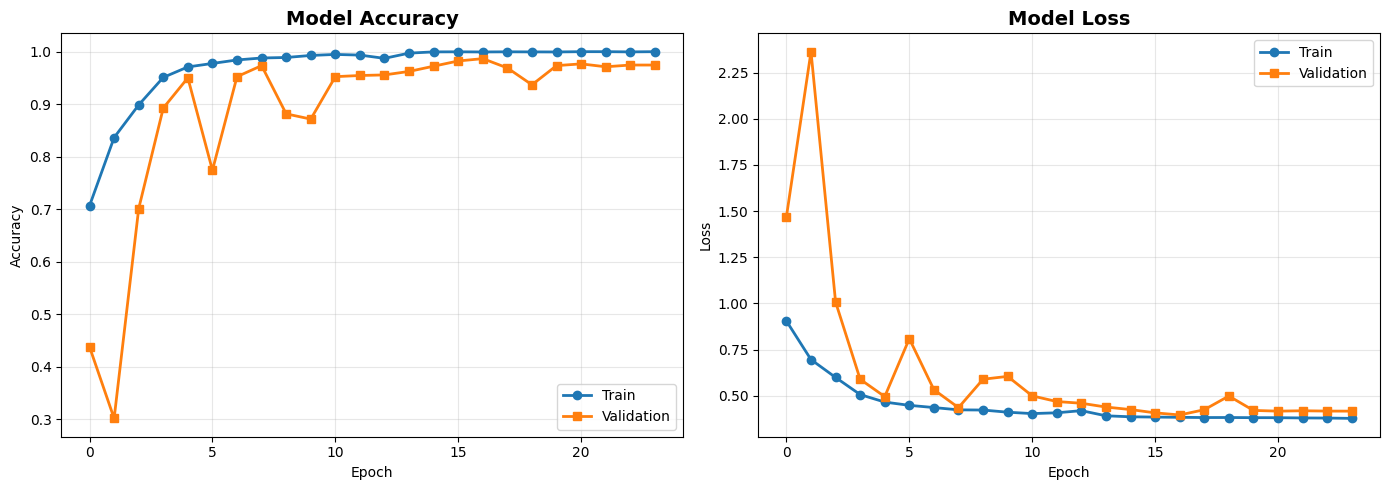


📊 FINAL METRICS:
   Best Train Accuracy: 1.0000 (100.00%)
   Best Val Accuracy: 0.9867 (98.67%)
   Best Val Loss: 0.3957
   Target ≥98.5%: ACHIEVED ✅


In [31]:
print("\n📈 Training history:\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(training_history.history['accuracy'], label='Train', linewidth=2, marker='o')
axes[0].plot(training_history.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(training_history.history['loss'], label='Train', linewidth=2, marker='o')
axes[1].plot(training_history.history['val_loss'], label='Validation', linewidth=2, marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Model_acc_model_loss.png', dpi=800)
plt.show()


# Final metrics
best_val_acc = max(training_history.history['val_accuracy'])
best_train_acc = max(training_history.history['accuracy'])
final_val_loss = min(training_history.history['val_loss'])

print(f"\n📊 FINAL METRICS:")
print(f"   Best Train Accuracy: {best_train_acc:.4f} ({best_train_acc*100:.2f}%)")
print(f"   Best Val Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Best Val Loss: {final_val_loss:.4f}")
print(f"   Target ≥98.5%: {'ACHIEVED ✅' if best_val_acc >= 0.985 else 'IN PROGRESS ⏳'}")

In [32]:
print(max(training_history.history['accuracy']))
print(max(training_history.history['val_accuracy']))
print(min(training_history.history['loss']))
print(min(training_history.history['val_loss']))

1.0
0.9867109656333923
0.37715044617652893
0.3957417905330658



📊 Evaluating model on Validation...

29/29 [==============================] - 2s 35ms/step
📋 CLASSIFICATION REPORT (VALIDATION)
                                            precision    recall  f1-score   support

                         Grape___Black_rot     0.9958    0.9553    0.9751       246
              Grape___Esca_(Black_Measles)     0.9664    0.9957    0.9808       231
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)     0.9905    1.0000    0.9952       209
                           Grape___healthy     0.9954    1.0000    0.9977       217

                                  accuracy                         0.9867       903
                                 macro avg     0.9870    0.9877    0.9872       903
                              weighted avg     0.9870    0.9867    0.9867       903


🎯 Weighted F1 Score: 0.9867
📊 Overall Accuracy:  0.9867


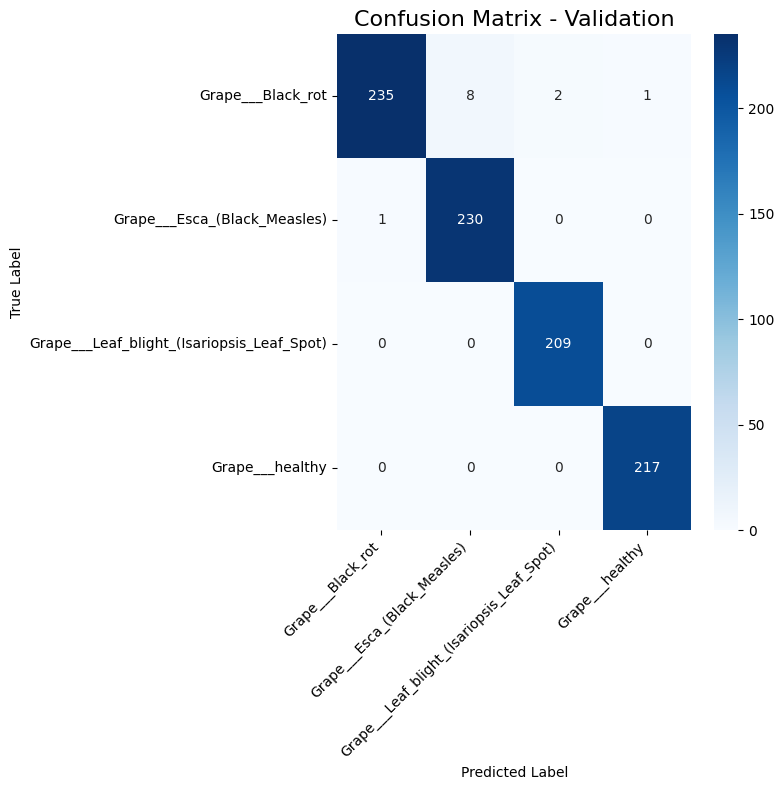


📊 Evaluating model on Test...

29/29 [==============================] - 1s 35ms/step
📋 CLASSIFICATION REPORT (TEST)
                                            precision    recall  f1-score   support

                         Grape___Black_rot     0.9954    0.9602    0.9775       226
              Grape___Esca_(Black_Measles)     0.9841    0.9920    0.9880       249
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)     0.9733    0.9910    0.9821       221
                           Grape___healthy     0.9808    0.9903    0.9855       206

                                  accuracy                         0.9834       902
                                 macro avg     0.9834    0.9833    0.9833       902
                              weighted avg     0.9835    0.9834    0.9833       902


🎯 Weighted F1 Score: 0.9833
📊 Overall Accuracy:  0.9834


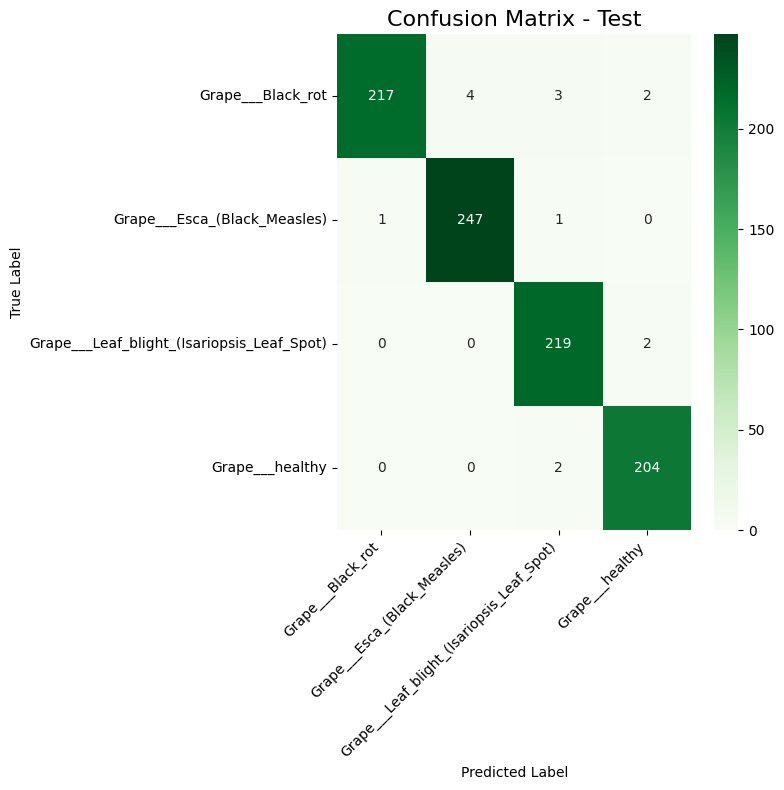


📊 FINAL SUMMARY

🔵 VALIDATION:
   Accuracy: 0.9867
   F1 Score: 0.9867

🟢 TEST:
   Accuracy: 0.9834
   F1 Score: 0.9833

Gap: 0.0033 ✅ Excellent generalization


In [39]:
def evaluate_dataset(model, dataset, class_names, dataset_name="Dataset", cmap="Blues"):
    print(f"\n📊 Evaluating model on {dataset_name}...\n")
    
    # We iterate once to get both Images (for prediction) and Labels (for truth)
    # This prevents alignment mismatches if the dataset was shuffled.
    images_list = []
    y_true_list = []
    
    for images, labels in dataset:
        images_list.append(images)
        y_true_list.append(labels)
        
    # Concatenate all batches
    x_all = tf.concat(images_list, axis=0)
    y_true_one_hot = tf.concat(y_true_list, axis=0)
    
    # Predict on the full set of images
    pred_probs = model.predict(x_all, verbose=1)
    
    # --- FIX: Convert One-Hot to Integers (Indices) ---
    y_pred = np.argmax(pred_probs, axis=1)      # Convert predictions to [0, 1, 2...]
    y_true = np.argmax(y_true_one_hot, axis=1)  # Convert true labels to [0, 1, 2...]
    
    # Classification Report
    print("="*80)
    print(f"📋 CLASSIFICATION REPORT ({dataset_name.upper()})")
    print("="*80)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # F1 Score
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = np.mean(y_pred == y_true) # Simple accuracy calculation

    print(f"\n🎯 Weighted F1 Score: {f1:.4f}")
    print(f"📊 Overall Accuracy:  {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 8)) # Slightly larger for readability
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name}', fontsize=16)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{dataset_name.lower()}.png', dpi=300)
    plt.show()

    return f1, acc


val_f1, val_acc = evaluate_dataset(model, validation_set, class_names, "Validation", "Blues")
test_f1, test_acc = evaluate_dataset(model, test_set, class_names, "Test", "Greens")


print("\n" + "="*80)
print("📊 FINAL SUMMARY")
print("="*80)

print(f"\n🔵 VALIDATION:")
print(f"   Accuracy: {val_acc:.4f}")
print(f"   F1 Score: {val_f1:.4f}")

print(f"\n🟢 TEST:")
print(f"   Accuracy: {test_acc:.4f}")
print(f"   F1 Score: {test_f1:.4f}")

gap = abs(val_f1 - test_f1)

if gap < 0.02:
    print(f"\nGap: {gap:.4f} ✅ Excellent generalization")
elif gap < 0.05:
    print(f"\nGap: {gap:.4f} ⚠️ Acceptable")
else:
    print(f"\nGap: {gap:.4f} ❌ Possible overfitting")

print("="*80)


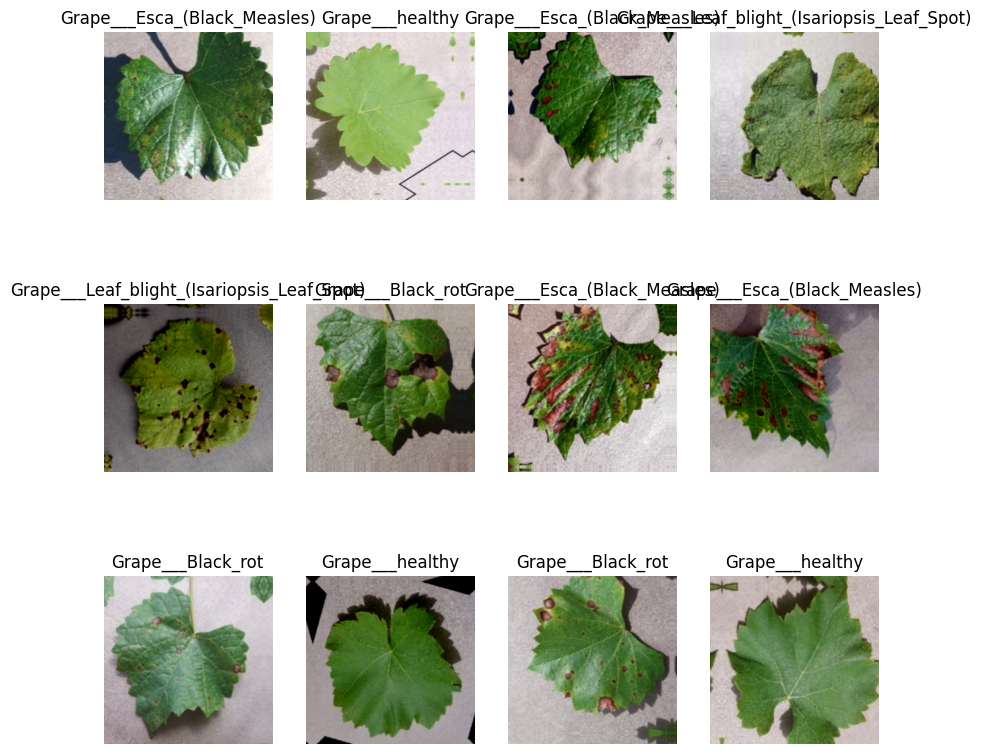

In [40]:
plt.figure(figsize=(10, 10))
# .take(1) grabs the first batch
for image_batch, labels_batch in training_set.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
        # FIX: Convert one-hot label to integer index
        label_index = np.argmax(labels_batch[i])
        plt.title(class_names[label_index])
        
        plt.axis("off")
plt.show()

first image to predict


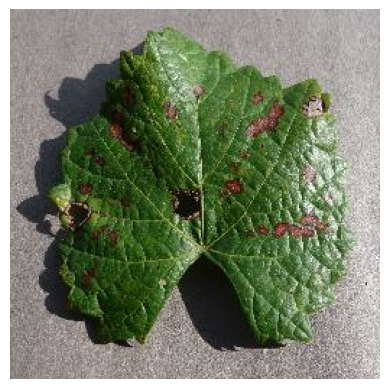

actual label: Grape___Esca_(Black_Measles)
1/1 [==============================] - 0s 32ms/step
predicted label: Grape___Esca_(Black_Measles)


In [41]:
for images_batch, labels_batch in test_set.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    plt.show()
    
    # FIX: Decode the actual label from one-hot
    actual_index = np.argmax(first_label)
    print("actual label:", class_names[actual_index])
    
    # Predict on the batch
    batch_prediction = model.predict(images_batch)
    
    # FIX: Decode the predicted label
    predicted_index = np.argmax(batch_prediction[0])
    print("predicted label:", class_names[predicted_index])
    
    # Break after one batch so we don't loop forever
    break

In [43]:
def predict(model, img):
    # 'img' is already a numpy array from the dataset
    # We just need to expand dimensions to make it a batch of 1: (1, 256, 256, 3)
    img_array = tf.expand_dims(img, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


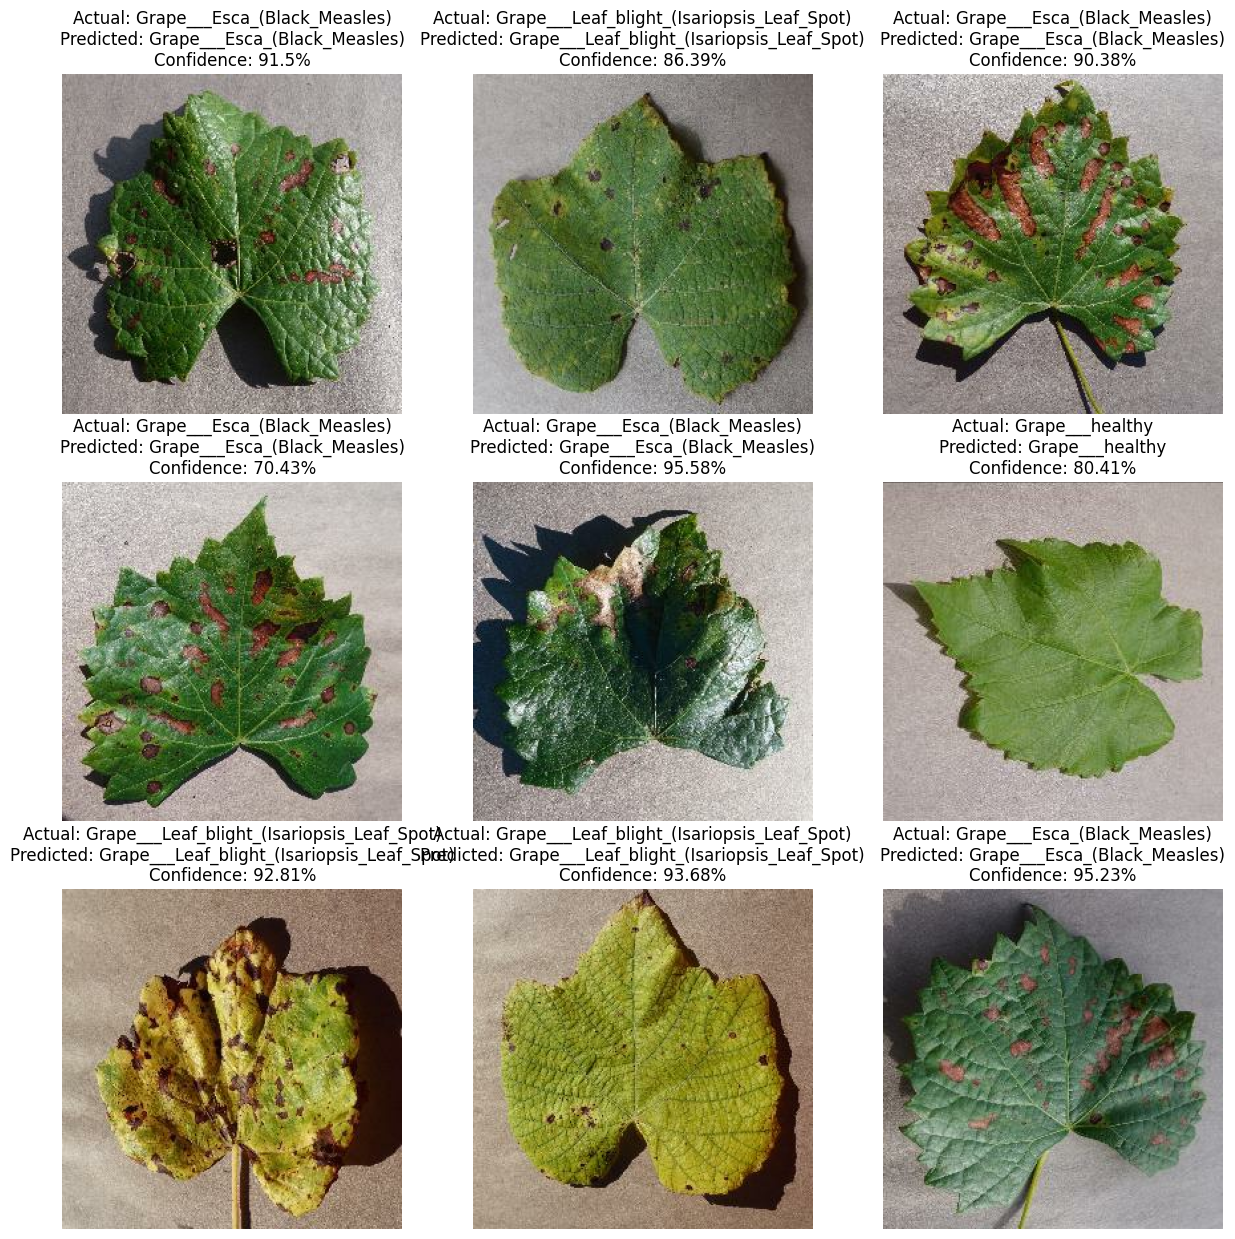

In [44]:
plt.figure(figsize=(15, 15))

for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Predict
        predicted_class, confidence = predict(model, images[i].numpy())
        
        # FIX: Get Actual Class from one-hot label
        actual_index = np.argmax(labels[i])
        actual_class = class_names[actual_index]
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

In [38]:
model.save_weights('Grape_model_weights_final_vg.h5')
model.save('Grape_custom_cnn_best_final_vg.keras')